In [2]:
%matplotlib inline
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from plot_utils import plot_snapshot
from synthetic_data import add_p_and_delta, load_data_by_gtype
from ic import make_partial_cascade
from noisy_binary_search import noisy_binary_search

In [28]:
gtype = 'grid'
param = '10'
dumps = load_data_by_gtype(gtype, param)
g = dumps[0]
sp_len = dumps[4]
g = add_p_and_delta(g, 1, 1)
if gtype == 'line':
    pos = [(i, 0) for i in g.nodes()]
elif gtype == 'grid':
    pos = {n: np.array([int(n/10), int(n%10)]) for n in g.nodes()}
else:
    pos = graphviz_layout(g, root='0')

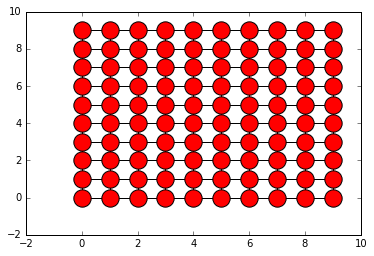

In [29]:
nx.draw_networkx(g, pos=pos, with_labels=False)

In [4]:
from copy import copy
from ic import sample_graph_from_infection


def median_node(g, mu, sp_len):
    return np.argmin(sp_len @ mu)

def noisy_binary_search(g,
                        source,
                        infection_times,
                        obs_nodes,
                        sp_len,
                        consistency_multiplier,
                        max_iter,
                        sampled_graphs,
                        uninfected_simulation_rounds=100,
                        debug=False,
                        save_log=False):
    """sp_len: 2d array of shortest path length
    """
    # observed from the plot in infection_probability_vs_fraction_of_shortest_path.ipynb
    mu = np.ones(g.number_of_nodes(), dtype=np.float)
    for n in obs_nodes:
        mu[n] = 0

    queried_nodes = copy(obs_nodes)
    queried_nodes_log = []
    mu_log = []

    for i in range(max_iter):
        if debug:
            print('source\'s mu: {:.2f}'.format(mu[source]))

        if len(queried_nodes) == g.number_of_nodes():
            break
        q = median_node(g, mu, sp_len)
        queried_nodes.add(q)

        if save_log:
            queried_nodes_log.append(q)

        if debug:
            print('query node: {}'.format(q))

        # check if q is source
        found_source = True
        for n in g.neighbors_iter(q):
            if infection_times[q] > infection_times[n]:
                found_source = False

        if found_source:
            assert q == source, '{} != {} ({} and {})'.format(
                q, source,
                infection_times[q],
                infection_times[source])
            if save_log:
                mu = np.zeros(g.number_of_nodes())
                mu[source] = 1
                mu_log.append(mu)
            break

        possible_ancestors = []
        # using just one ancestor node
        for n in g.neighbors_iter(q):
            queried_nodes.add(n)
            if save_log:
                # querie_nodes_log.append(n)
                pass
            if infection_times[q] - infection_times[n] == g[n][q]['d']:
                possible_ancestors.append(n)
                break

        if debug:
            print('ancestor nodes: {}'.format(possible_ancestors))

        if len(possible_ancestors) > 0:
            for a in possible_ancestors:
                for n in g.nodes_iter():
                    if sp_len[n, q] == (sp_len[n, a] + g[a][q]['d']):
                        mu[n] *= consistency_multiplier
                    else:
                        mu[n] *= (1 - consistency_multiplier)
        if save_log:
            mu_log.append(copy(mu))

    query_count = len(queried_nodes - obs_nodes)
    if debug:
        print('used {} queries to find the source'.format(query_count))
    if save_log:
        return query_count, queried_nodes_log, mu_log
    else:
        return query_count

In [30]:
import numpy as np
import math
import matplotlib as mpl
import networkx as nx
from matplotlib import pyplot as plt
from cycler import cycler
from utils import infeciton_time2weight


def plot_snapshot(g, pos,
                  node2weight,
                  ax=None,
                  query_node=None,
                  queried_nodes=None,
                  source_node=None,
                  max_node_size=1000):
    weights = node2weight.values()
    node2weight[source_node] *= 2
    vmin, vmax = min(weights), max(weights)

    def node_color(n):
        return node2weight[n]

    def node_shape(n):
        if n == query_node:
            return '^'
        elif n == source_node:
            return '*'
        elif queried_nodes and n in queried_nodes:
            return 's'
        else:
            return 'o'
    node2shape = {n: node_shape(n) for n in g.nodes()}

    def node_size(n):
        if n == source_node:
            return max_node_size / 2
        elif n == query_node:
            return max_node_size / 2
        elif queried_nodes and n in queried_nodes:
            return max_node_size / 4
        elif node2weight[n] != 0:
            return max_node_size / 12
        else:
            return max_node_size / 12

    # draw by shape
    if ax is None:
        ax = None
    all_shapes = set(node2shape.values())
    for shape in all_shapes:
        nodes = [n for n in g.nodes() if node2shape[n] == shape]
        nx.draw_networkx_nodes(g, pos=pos,
                               ax=ax,
                               node_shape=shape,
                               node_color=list(map(node_color, nodes)),
                               node_size=list(map(node_size, nodes)),
                               nodelist=nodes,
                               with_labels=False,
                               cmap='OrRd',
                               vmin=vmin,
                               vmax=vmax)
    nx.draw_networkx_edges(g, pos=pos, ax=ax)

In [31]:
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.01)
query_count, queried_nodes, mu_list = noisy_binary_search(g, source, infection_times, obs_nodes=set(), 
                                                 sampled_graphs=None,
                                                 sp_len=sp_len, consistency_multiplier=1.0,
                                                 max_iter=g.number_of_nodes(),
                                                 debug=False,
                                                 save_log=True)
print('source is {}'.format(source))

source is 20


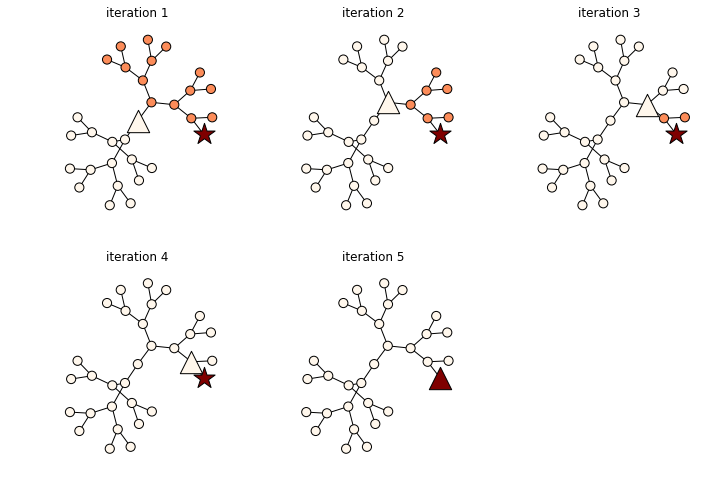

In [17]:
if gtype == 'grid':
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for i, (q, mu) in enumerate(zip(queried_nodes, mu_list)):
        j, k = int(i / 3), i % 3
        mu = {i: v for i, v in enumerate(mu)}
        plot_snapshot(g, pos, ax=ax[j, k], node2weight=mu,
                      source_node=source, query_node=q)
        ax[j, k].set_title('iteration {}'.format(i+1))
        ax[j, k].axis('off')
elif gtype == 'line':
    fig, ax = plt.subplots(4, figsize=(8, 4))
    for i, (q, mu) in enumerate(zip(queried_nodes, mu_list)):
        mu = {i: v for i, v in enumerate(mu)}
        plot_snapshot(g, pos, ax=ax[i], node2weight=mu,
                      source_node=source, query_node=q)
        ax[i].set_title('iteration {}'.format(i+1))
        ax[i].axis('off')
elif gtype == 'balanced-tree':
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for i, (q, mu) in enumerate(zip(queried_nodes, mu_list)):
        j, k = int(i/3), i%3
        mu = {i: v for i, v in enumerate(mu)}
        plot_snapshot(g, pos, ax=ax[j, k], node2weight=mu,
                      source_node=source, query_node=q)
        ax[j, k].set_title('iteration {}'.format(i+1))
        ax[j, k].axis('off')
    ax[1, 2].axis('off')
fig.savefig('figs/presentation/{}-process.png'.format(gtype))

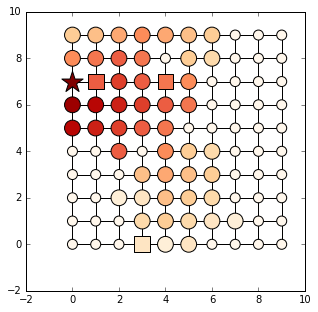

In [38]:
from plot_utils import plot_snapshot
g = add_p_and_delta(g, 0.5, 1)
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.05)

fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_snapshot(g, pos, infeciton_time2weight(infection_times), source_node=source, queried_nodes=obs_nodes, ax=ax)

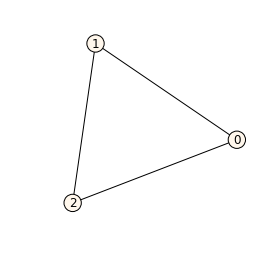

In [20]:
g = nx.complete_graph(3)
fig, ax = plt.subplots(1, 1, figsize=(4,4))
nx.draw_networkx(g, with_labels=True, node_color=[0, 0, 0], ax=ax, cmap='OrRd')
ax.axis('off')
fig.savefig('figs/presentation/triangle.png')

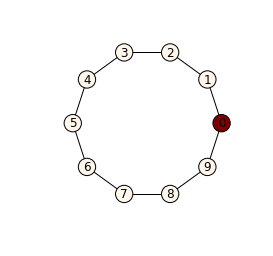

In [27]:
g = nx.path_graph(10)
g.add_edge(0, 9)
fig, ax = plt.subplots(1, 1, figsize=(4,4))
nx.draw_circular(g, with_labels=True, node_color=[1] + [0]*9, ax=ax, cmap='OrRd')
ax.axis('off')
fig.savefig('figs/presentation/circular.png')